## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

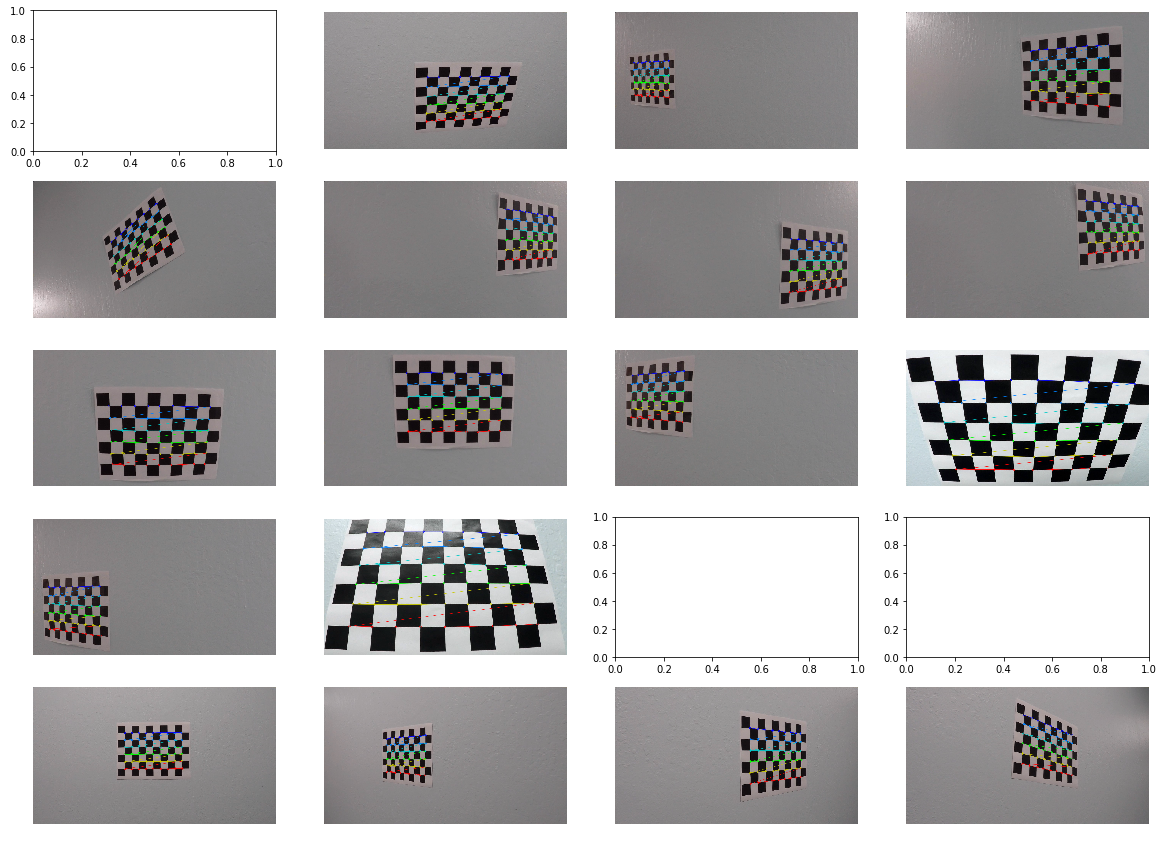

In [19]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

f, axs = plt.subplots(5,4, figsize=(20, 15))
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)


## Undistort and draw corners on chessboard

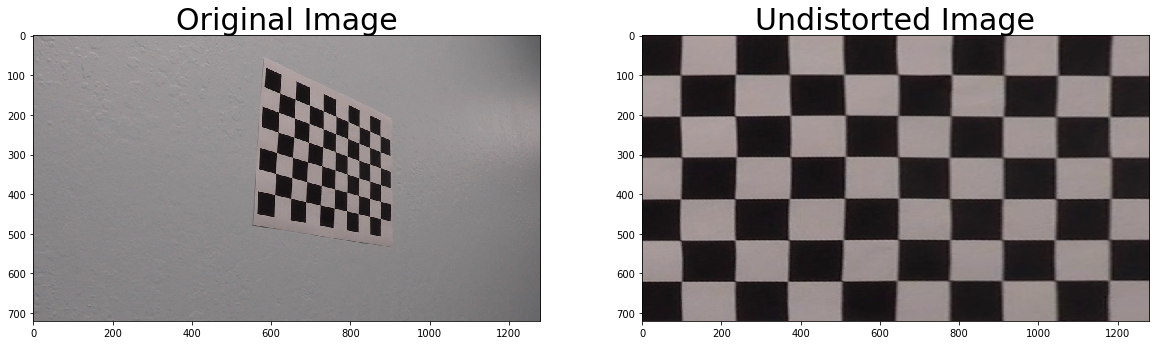

In [113]:
#Draw corners on raw images
import os
%matplotlib inline
    
def corners_unwarp(img, nx, ny, mtx, dist):
    # Undistort using mtx and dist
    undistorted = cv2.undistort(img, mtx,dist,None,mtx)
    # Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    warped = np.zeros_like(undistorted)
    M = np.zeros_like(undistorted)
    if ret == True:
        #draw corners
       # image = cv2.drawChessboardCorners(undistorted,(nx,ny),corners,ret)
        img_size = (gray.shape[1], gray.shape[0])
        # offset for dst points
        offset = 100 
        #define 4 source points src = np.float32([[,],[,],[,],[,]]) that define a rectangle

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        #define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        #get the transform matrix
        M = cv2.getPerspectiveTransform(src,dst)
        #warp image to a top-down view
        warped = cv2.warpPerspective(undistorted, M,img_size,flags=cv2.INTER_LINEAR)
    return warped, M

# unwarp all images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the images directory and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
    #print(os.path.basename(fname))
    cv2.imwrite('../output_images/' + os.path.basename(fname),top_down)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Undistorted Image', fontsize=30)

# Undistorting road images

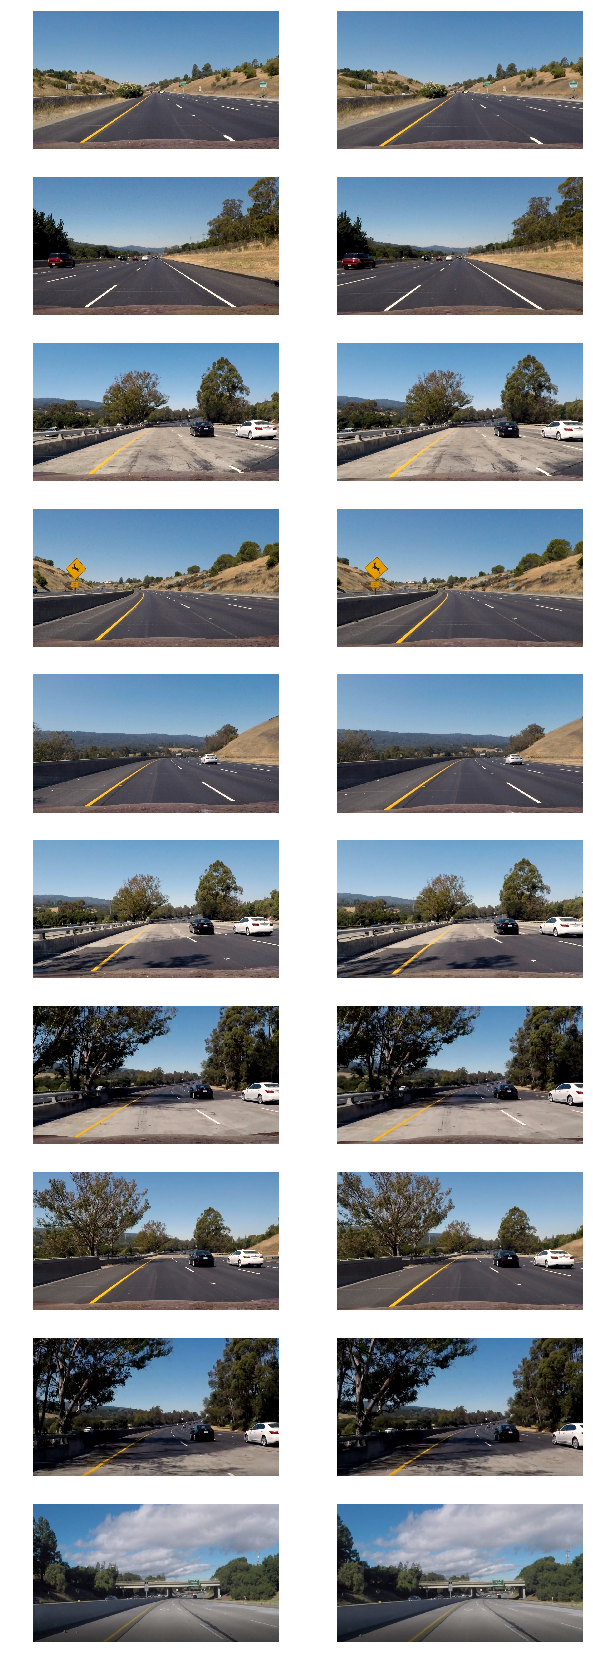

In [49]:
#Create a threshold binary image
import matplotlib.image as mpimg
#Apply distortion correction to raw images
def undistort(img):
    img_size = (img.shape[1], img.shape[0])    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

images = glob.glob('test_images/*.jpg')
# Visualize undistortion on test images
out_dir='output_images/'
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img)
    image_name=os.path.split(fname)[1]
    write_name = out_dir + image_name
    cv2.imwrite(write_name,dst)
    #cv2.imshow('dst', dst)
    #cv2.waitKey(500)
    
#cv2.destroyAllWindows()
                                          
f, axs = plt.subplots(len(images),2, figsize=(10, 30))
axs = axs.ravel()
                  
i = 0
for image in images:
    img = mpimg.imread(image)
    undistorted = undistort(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(undistorted)
    axs[i].axis('off')
    i += 1


# Threshold definitions

In [33]:
%matplotlib inline

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient == 'x'):
        #Calculating the derivative in x direction 1,0
        sobel_orient = cv2.Sobel(gray,cv2.CV_64F,1,0)
    else:
        #Calculating the derivative in y direction 0,1
        sobel_orient = cv2.Sobel(gray,cv2.CV_64F,0,1)
    
    # 3) Take the absolute x or y derivative to
    # accentuate lines away from horizontanl or vertical
    abs_sobel = np.absolute(sobel_orient)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    #identify pixels where the gradient of an image falls within a specified threshold range.
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
     # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude / absolute value
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    #identify pixels where the gradient of an image falls within a specified threshold range.
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    #identify pixels where the gradient of an image falls within a specified threshold range.
    dir_binary[(direction>=thresh[0]) & (direction<= thresh[1])] = 1
    return dir_binary

def hls_h_threshold(image, thresh=(15, 25)):
    # Convert to HLS 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #To detect yellow lines
    h_channel = hls[:,:,0]
    # Apply normalization 
    #h_channel = h_channel*(255/np.max(h_channel))  
    # Threshold color channel - To detect white lines
    h_binary = np.zeros_like(h_channel)    
    h_binary[((h_channel > thresh[0]) & (h_channel <= thresh[1]))] = 1  
    return h_binary

def hls_l_threshold(image, thresh=(200, 255)):
    # Convert to HLS 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    # Apply normalization 
    l_channel = l_channel*(255/np.max(l_channel))  
    # Threshold color channel - To detect white lines
    l_binary = np.zeros_like(l_channel)    
    l_binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1  
    return l_binary
    
def hls_s_threshold(image, thresh=(125, 255)):
    # Convert to HLS 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 125
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel > s_thresh_min))] = 1
    return s_binary

#A high value in A or B channel represents a color having more red or yellow and a low value represents a color having 
#more green or blue.Since the shadow regions are darker and less illuminated than the surroundings, it is easy to locate 
#them in the L channel since the L channel gives lightness information. The B channel values are also lesser in the shadow
#areas in most of the outdoor images. Thus combining the values from L and B channels, the pixels with values less than a
#threshold are identified as shadow pixels, and others as non-shadow pixels. 

def lab_l_threshold(image, thresh=(100, 255)):
     #convert RGB image to LAB image
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #values range from 0-100 (black to white)
    l_channel = lab[:,:,0]
    #values range from -128 to +127 (gives red to green ratio)
    a_channel = lab[:,:,1]
    #values range from -128 to +127 (gives yellow to blue ratio)
    b_channel = lab[:,:,2]  
    
    l_thresh = thresh[0]
    #compute threshold for shadow pixels   
    if int(np.mean(a_channel) + np.mean(b_channel))<= 256:
        l_thresh = np.mean(l_channel) - np.std(l_channel)/3
            
    #pixels with lower values in both L and B planes can be classified as shadow pixels and others
    #as non-shadow pixels
    l_binary = np.zeros_like(l_channel)
    l_binary[((l_channel > l_thresh))] = 1  
        
    return l_binary
    
def lab_b_threshold(image, thresh=(190, 255)):
     #convert RGB image to LAB image
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #values range from -128 to +127 (gives yellow to blue ratio)
    b_channel = lab[:,:,2]    
    # normalize image if yellow found in the image
    if np.max(b_channel) > 175:
        b_channel = b_channel*(255/np.max(b_channel)) 
    b_binary = np.zeros_like(b_channel)    
    b_binary[((b_channel > thresh[0]) & (b_channel <= thresh[1]))] = 1
    return b_binary

# Examples of Thresholds

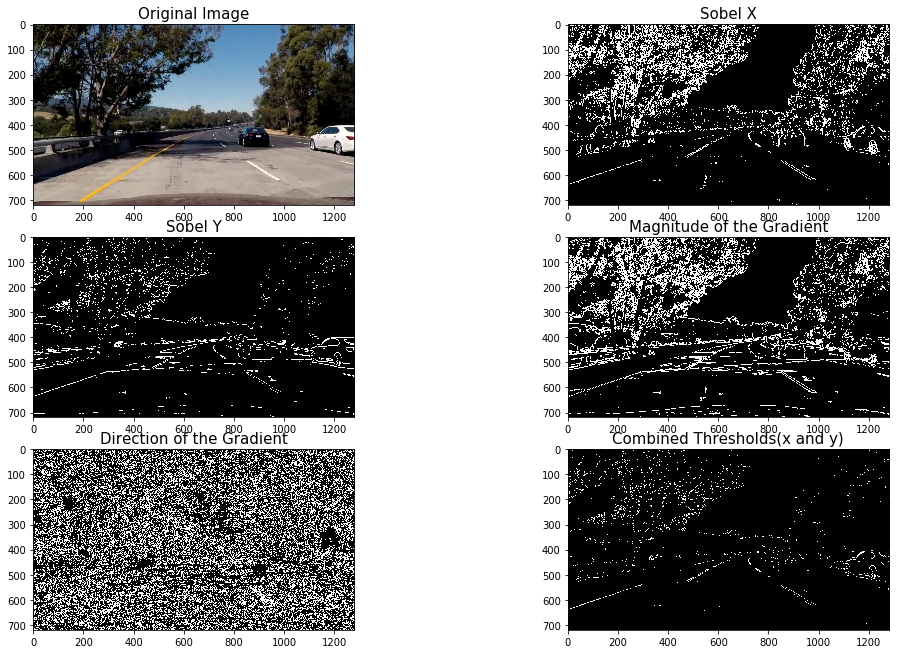

In [23]:
image = mpimg.imread('output_images/test5.jpg')
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(16, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(25, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(grady)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((gradx == 1) & (grady == 1))] = 1

# Plot the result
f, axs = plt.subplots(3,2,figsize=(15, 9))
f.tight_layout()
axs[0][0].imshow(image)
axs[0][0].set_title('Original Image', fontsize=15)
axs[0][1].imshow(gradx, cmap='gray')
axs[0][1].set_title('Sobel X', fontsize=15)
axs[1][0].imshow(grady, cmap='gray')
axs[1][0].set_title('Sobel Y', fontsize=15)
axs[1][1].imshow(mag_binary, cmap='gray')
axs[1][1].set_title('Magnitude of the Gradient', fontsize=15)
axs[2][0].imshow(dir_binary, cmap='gray')
axs[2][0].set_title('Direction of the Gradient', fontsize=15)
axs[2][1].imshow(combined, cmap='gray')
axs[2][1].set_title('Combined Thresholds(x and y)', fontsize=15)

# Working with HLS color space

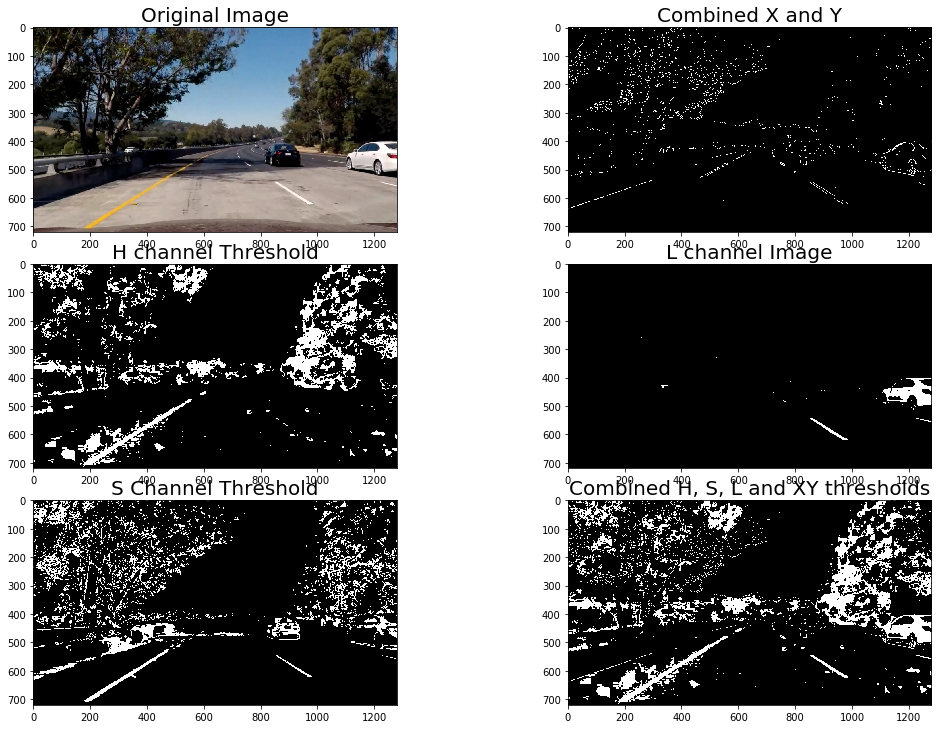

In [53]:
def combined_threshold_hls(img, thresh_image):
    # HLS color space
    h_binary = hls_h_threshold(img)
    l_binary= hls_l_threshold(img)
    s_binary = hls_s_threshold(img)     

    # Stack each channel to view their individual contributions
    #in green and blue respectively
    # This returns a stack of the two binary images, whose 
    #components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(thresh_image), thresh_image, s_binary)) * 255

    #combine the two binary thresholds
   # combined_binary = np.zeros_like(s_binary)
    #combined_binary[(s_binary == 1) | (l_binary == 1) | (thresh_image ==1)] = 1
    combined_binary = np.zeros_like(h_binary)
    combined_binary[((s_binary == 1) & (thresh_image ==1)) | ((h_binary ==1)) | ((l_binary ==1) | (thresh_image ==1))] = 1
    return combined_binary,h_binary, s_binary,l_binary

image = mpimg.imread('output_images/test5.jpg')
ksize = 3# Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(25, 100))
dir_binary = dir_threshold(image, sobel_kernel=7, thresh=(0.7, 1.3))

combined = np.zeros_like(grady)
combined[((gradx == 1) & (grady == 1))] = 1
#image = mpimg.imread('../output_images/stage1/test2.jpg')
combined_binary,h_binary, s_binary,l_binary =  combined_threshold_hls(image, combined)  

# Plot the result
f, axs = plt.subplots(3,2,figsize=(15, 10))
f.tight_layout()
axs[0][0].imshow(image)
axs[0][0].set_title('Original Image', fontsize=20)
axs[0][1].imshow(combined, cmap='gray')
axs[0][1].set_title('Combined X and Y', fontsize=20)
axs[1][0].imshow(h_binary, cmap='gray')
axs[1][0].set_title('H channel Threshold', fontsize=20)
axs[1][1].imshow(l_binary, cmap='gray')
axs[1][1].set_title('L channel Image', fontsize=20)
axs[2][0].imshow(s_binary, cmap='gray')
axs[2][0].set_title('S Channel Threshold', fontsize=20)
axs[2][1].imshow(combined_binary, cmap='gray')
axs[2][1].set_title('Combined H, S, L and XY thresholds', fontsize=20)

# Working with LAB B channel and HLS L channel

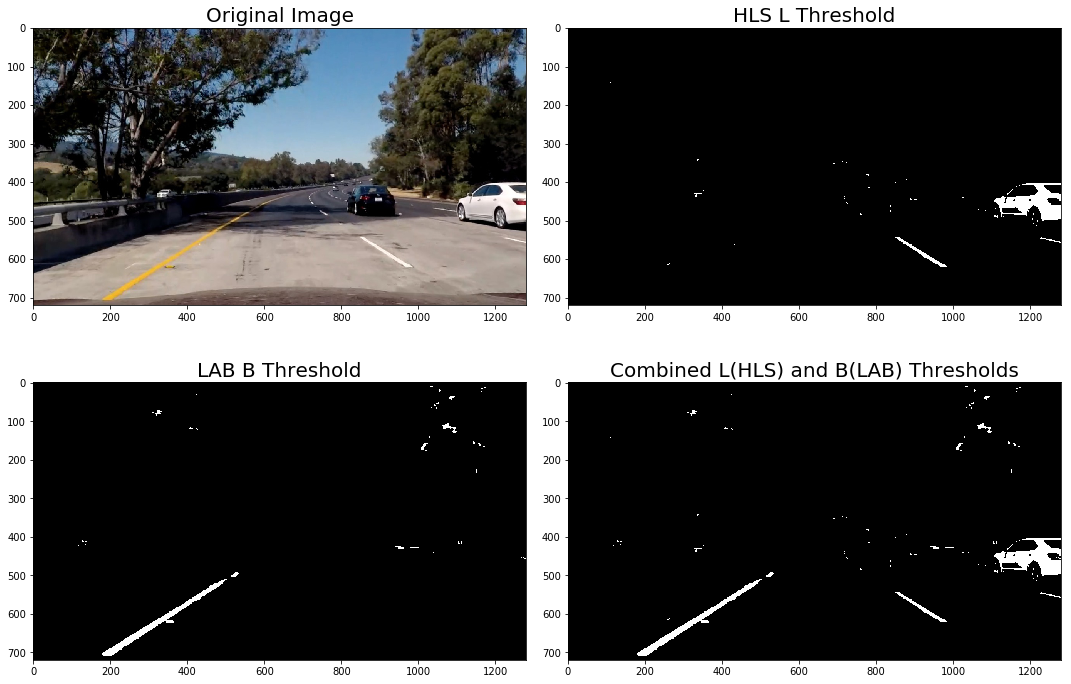

In [54]:
def combined_threshold(img):
    # HLS L channel Threshold - To detect white lines
    l_binary_hls = hls_l_threshold(img)
    
    # LAB L channel to detect shadows in an image
    l_binary = lab_l_threshold(img)
    
    # HLS L channel Threshold - To detect yellow lines
    s_binary = hls_s_threshold(img)  
    
    #LAB B channel to detect yellow lines
    b_binary = lab_b_threshold(img)
    
    #combine to detect shadows 
    #combined_lb = np.zeros_like(b_binary)
    #combined_lb[((l_binary == 1) | (b_binary ==1))] = 1
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[((l_binary_hls ==1) | (b_binary ==1))] = 1
    
    return combined_binary, l_binary_hls, b_binary

image = mpimg.imread('output_images/test5.jpg')
combined_binary, l_binary_hls, b_binary = combined_threshold(image)

f, axs = plt.subplots(2,2,figsize=(15, 10))
f.tight_layout()
axs[0][0].imshow(image)
axs[0][0].set_title('Original Image', fontsize=20)
axs[0][1].imshow(l_binary_hls, cmap='gray')
axs[0][1].set_title('HLS L Threshold', fontsize=20)
axs[1][0].imshow(b_binary, cmap='gray')
axs[1][0].set_title('LAB B Threshold', fontsize=20)
axs[1][1].imshow(combined_binary, cmap='gray')
axs[1][1].set_title('Combined L(HLS) and B(LAB) Thresholds', fontsize=20)


# Region of Interest

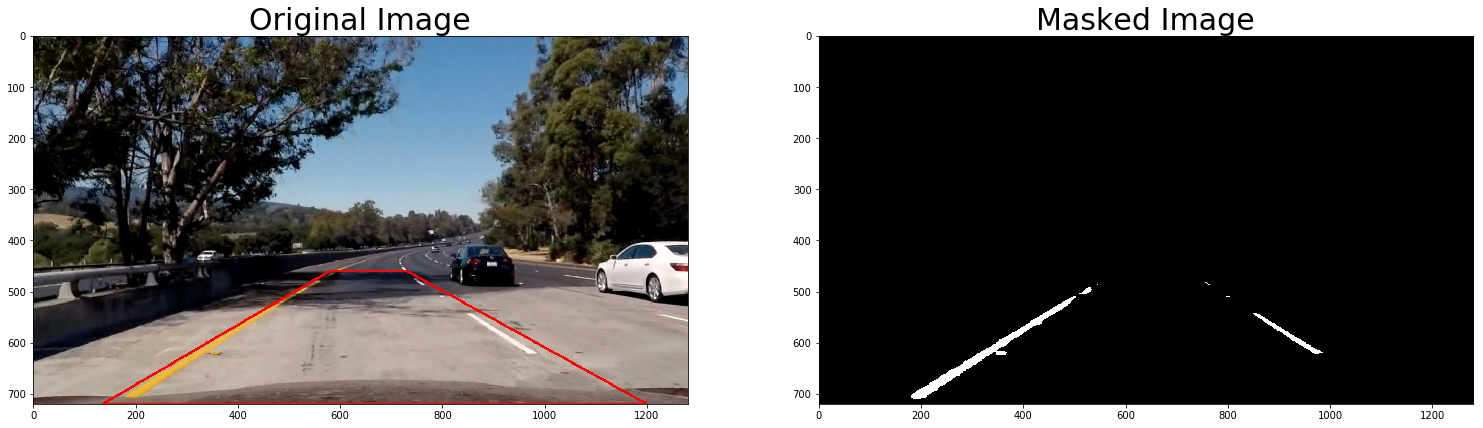

In [55]:
#select region of interest in the image
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #define a 4 sided polygon to mask
    imshape = img.shape     
    #vertices = np.array([[(135,imshape[0]),(580, 460), (730, 460), (1200,imshape[0])]], dtype=np.int32)
    vertices = np.array([[(135,imshape[0]),(580, 460), (730, 460), (1200,imshape[0])]], dtype=np.int32)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

masked_img = region_of_interest(combined_binary)

imshape = img.shape  
vertices = np.array([[(135,imshape[0]),(580, 460), (730, 460), (1200,imshape[0])]], dtype=np.int32)
#draw polygon on original image
vertices = vertices.reshape((-1,1,2))
img_copy = np.copy(image)
cv2.polylines(img_copy,[vertices],True,(255,0,0), thickness=3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_copy)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(masked_img,cmap='gray')
ax2.set_title('Masked Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective transform

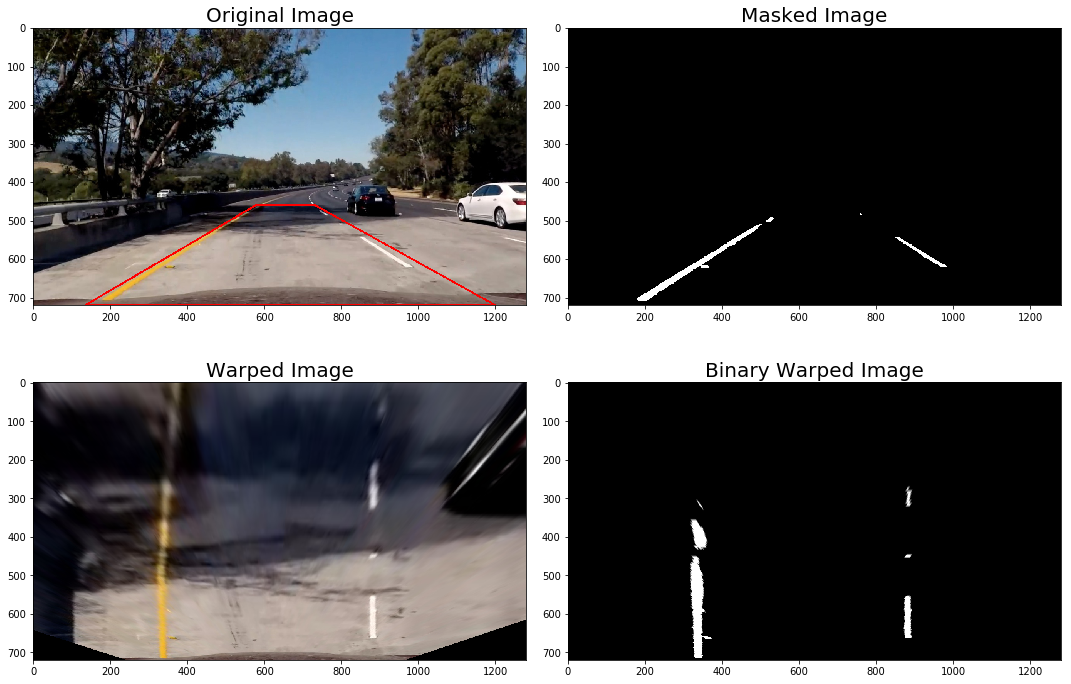

In [56]:
#Apply Warp Perspective
def perspective_transform(image):
    #undistort an image
    #undist = cv2.undistort(image, mtx, dist, None, mtx)
    #define source points src = np.float32([[,],[,],[,],[,]]), using masked vertices
    imgsize = (image.shape[1], image.shape[0])
    pts = vertices.reshape(4, 2)
    src = np.float32([pts[0],pts[3], pts[2], pts[1] ])

    #chose destination points 
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 0]
    top_right = [920, 0]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])

    #get the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    #warp image to a top-down view
    binary_warped = cv2.warpPerspective(image, M,imgsize,flags=cv2.INTER_LINEAR)
    
    return binary_warped,M, Minv

binary_warped,M,Minv = perspective_transform(masked_img)    
warped,_,_ = perspective_transform(image)   

f, axs = plt.subplots(2,2,figsize=(15, 10))
f.tight_layout()
axs[0][0].imshow(img_copy)
axs[0][0].set_title('Original Image', fontsize=20)
axs[0][1].imshow(masked_img, cmap='gray')
axs[0][1].set_title('Masked Image', fontsize=20)
axs[1][0].imshow(warped)
axs[1][0].set_title('Warped Image', fontsize=20)
axs[1][1].imshow(binary_warped, cmap='gray')
axs[1][1].set_title('Binary Warped Image', fontsize=20)


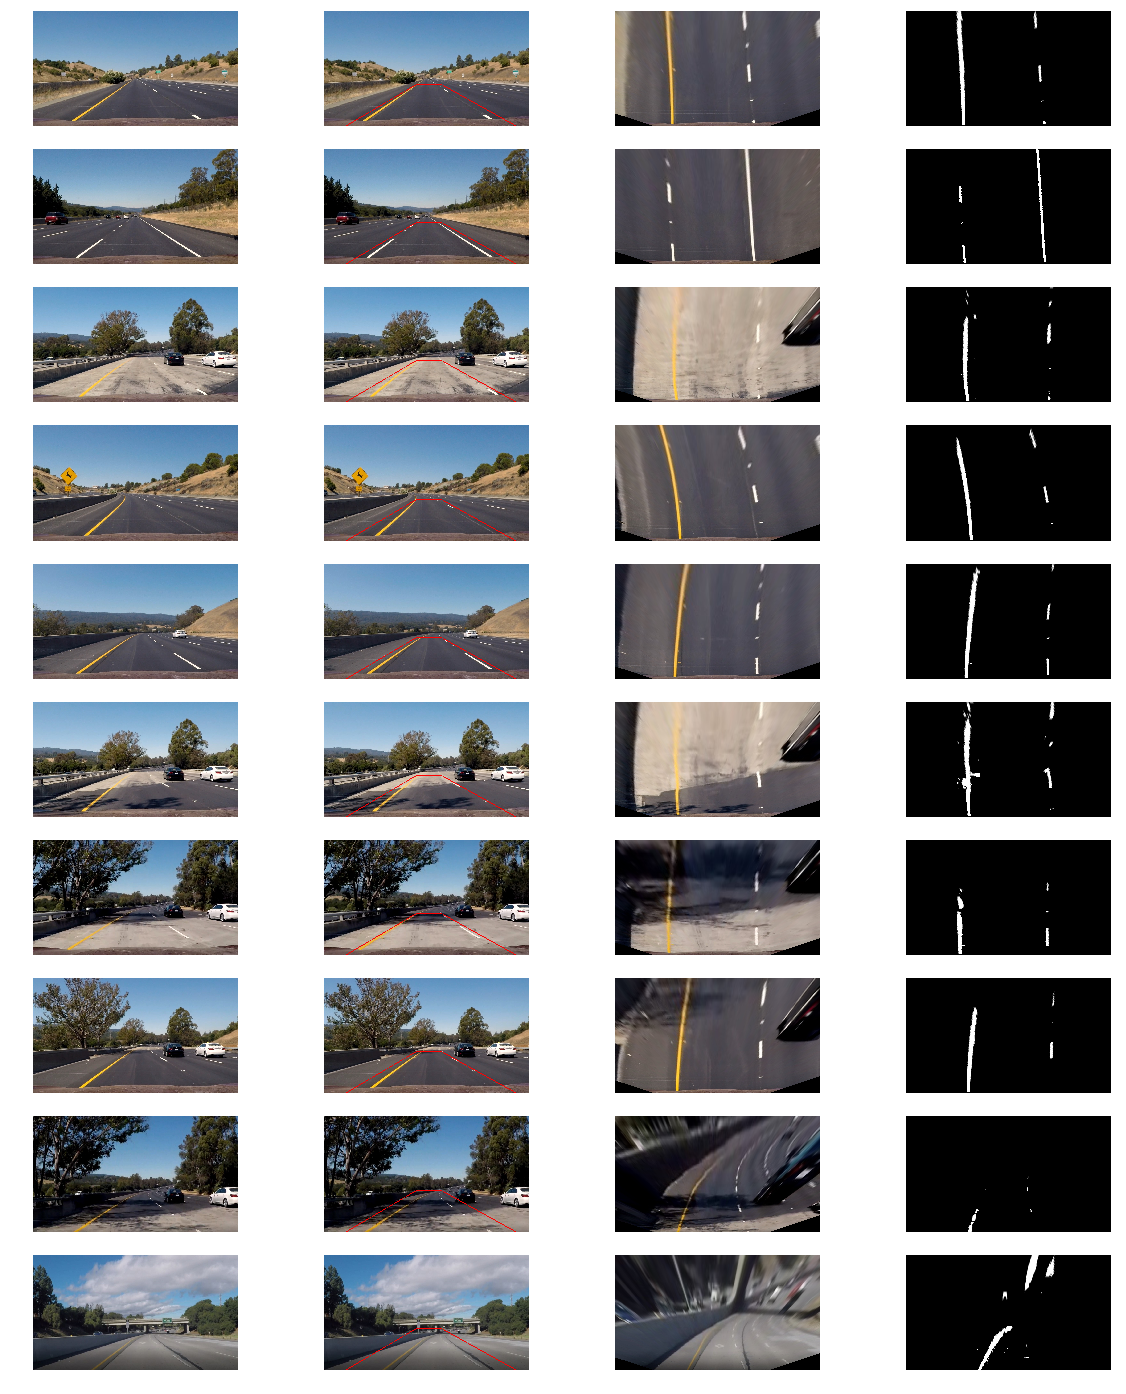

In [57]:
#running pipeline on all test images
def pipeline(image):
    #Apply distortion correction to raw images.
    undistorted = undistort(image)

    #get combined binary image
    combined_binary,_,_,=  combined_threshold(undistorted) 

    #mask image
    masked_img = region_of_interest(combined_binary)

    #perspective transform
    binary_warped,M,Minv = perspective_transform(masked_img)
    
    return binary_warped,M,Minv
    
    # Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
f, axs = plt.subplots(len(images),4, figsize=(20, 25))
axs = axs.ravel()
                  
i = 0
for image in images:
    img = mpimg.imread(image)
    warped,_,_ = perspective_transform(img)
    binary_warped,_,_ = pipeline(img)  
    img_copy = np.copy(img)
    cv2.polylines(img_copy,[vertices],True,(255,0,0), thickness=3)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_copy)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(warped, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(binary_warped, cmap='gray')
    axs[i].axis('off')
    i += 1
    
    

# Implement Sliding Windows 

In [58]:
def blind_search(binary_warped):
    # Take a histogram of the bottom half of the image
    # adding up the pixel values along each column in the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

    # Break image into 9 vertical layers since image height is 720
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
   
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # append windows to rectangles
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    left_fit, right_fit = None, None 
    if len(leftx) == 0:
        left_fit = None
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if len(rightx) == 0:
        right_fit = None
    else:
        right_fit = np.polyfit(righty, rightx, 2) 
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,rectangles

#previous_left_fit,previous_right_fit,left_lane_inds,right_lane_inds,rectangles = blind_search(binary_warped)

#print(rectangles)

In [59]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
#out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
quarter_point = np.int(midpoint//2)
leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

print("mid point: ", midpoint)
print("quarter point: ", quarter_point)
print("left base: ", leftx_base)
print("right base: ", rightx_base)

mid point:  640
quarter point:  320
left base:  550
right base:  640


(720, 0)

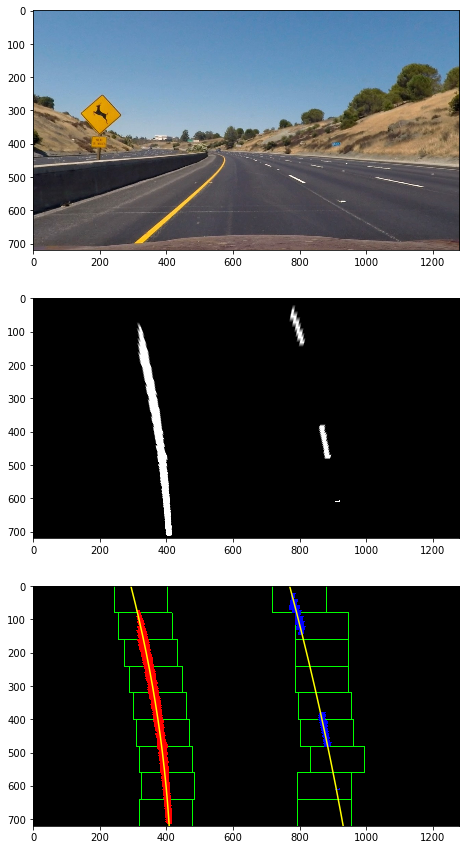

In [60]:
#pipeline for sliding window using blind search
image = mpimg.imread('test_images/test2.jpg')
undistorted = undistort(image)
binary_warped,M,Minv = pipeline(image)  

#Detect lane pixels and fit to find the lane boundary    
left_fit,right_fit,left_lane_inds,right_lane_inds,rectangles = blind_search(binary_warped)

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Draw the windows on the rectangles saved in blind_search
for rect in rectangles:
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.imshow(undistorted)
plt.subplot(3,1,2)
plt.imshow(binary_warped, cmap='gray')
plt.subplot(3,1,3)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


# Fit a Polynomial using previous fits

In [61]:
#Once we know where the left and right line are using left_fit and right_fit, we 
#can just use the previous line positions without doing a blind search again
def quick_lane_finder(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
     # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit = None
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if len(rightx) == 0:
        right_fit = None
    else:
        right_fit = np.polyfit(righty, rightx, 2) 
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds

(720, 0)

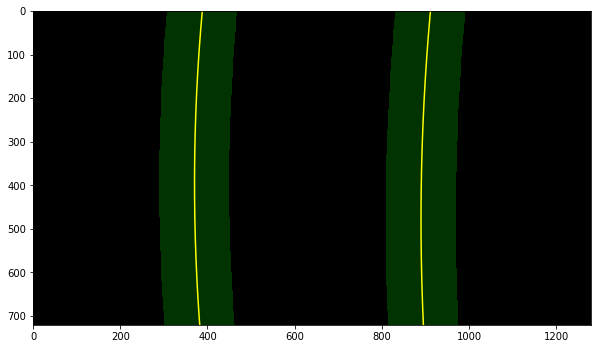

In [62]:
#pipeline for sliding window using quick lane finder, once we have fits from earlier search
image2 = mpimg.imread('test_images/test1.jpg')
undistorted2 = undistort(image2)
binary_warped2,_,_ = pipeline(image2)  

left_fit2,right_fit2,left_lane_inds2,right_lane_inds2 = quick_lane_finder(binary_warped2, left_fit, right_fit)
margin = 80
nonzero = binary_warped2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Create an image to draw on and an image to show the selection window
out_img2 = np.dstack((binary_warped2, binary_warped2, binary_warped2))*255
window_img2 = np.zeros_like(out_img2)
# Color in left and right line pixels
out_img2[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped2.shape[0]-1, binary_warped2.shape[0] )
left_fitx = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                                                ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img2, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img2, np.int_([right_line_pts]), (0,255, 0))

result = cv2.addWeighted(out_img2, 1, window_img2, 0.3, 0)



plt.figure(figsize=(10,10))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Radius of Curvature

In [63]:
#Radius of curvature in pixel space
def radius_curvature_pixels(binary_warped,left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

left_curverad, right_curverad = radius_curvature_pixels(ploty,left_fit, right_fit)

print('Radius of Curvature in pixel space: ',left_curverad, right_curverad)

Radius of Curvature in pixel space:  3725.50277268 8707.05942861


In [103]:
#Radius of curvature in world space, in meters
def radius_of_curvature(binary_warped,left_fitx, right_fitx):
    img_size = binary_warped.shape
    ploty = np.linspace(0, img_size[0]-1, img_size[0] )
    left_curverad, right_curverad = 0,0 
    #y vlues of image increases from top to bottom;
    #to measure radius of curvature closest to the vehicle, I'll choose the maximum y-value, 
    #corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    #U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, 
    #and the dashed lane lines are 10 ft = 3.048 meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/510 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    return left_curverad, right_curverad

left_curverad, right_curverad = radius_of_curvature(binary_warped,left_fitx, right_fitx)  
average_curverad = (left_curverad + right_curverad)/2

# compute the offset from the center
lane_center = (left_fitx[719] + right_fitx[719])/2
xm_per_pix = 3.7/500 # meters per pixel in x dimension
center_offset_pixels = abs(binary_warped.shape[1]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels

#print all values
leftcurv_string = "Left curvature: %.2f m" % left_curverad
rightcurv_string = "Right curvature: %.2f m" % right_curverad
averagecurv_string = "Average curvature: %.2f m" % average_curverad
offset_string = "Center offset: %.2f m" % center_offset_mtrs

print(leftcurv_string)
print(rightcurv_string)
print(averagecurv_string)
print(offset_string)


Left curvature: 563.77 m
Right curvature: 678.37 m
Average curvature: 621.07 m
Center offset: 0.01 m


# Draw the measurement back down onto the road

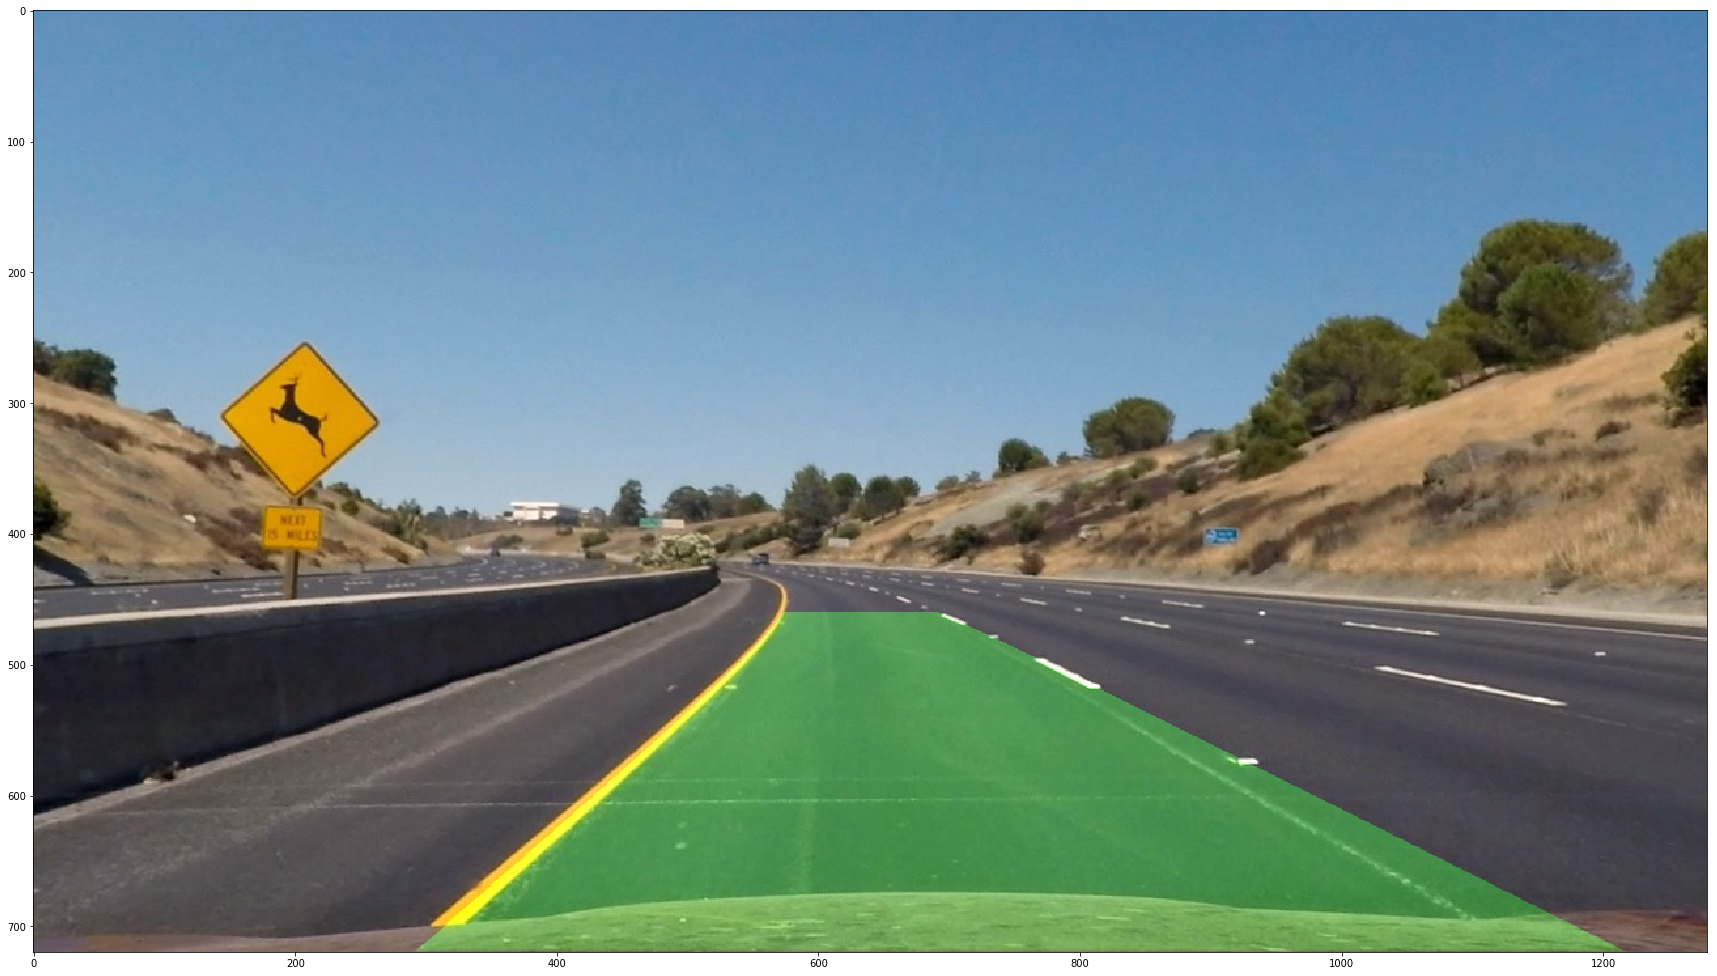

In [114]:
# Create an image to draw the lines on
def drawLine(binary_warped,left_fit, right_fit, Minv, image):
    if left_fit is None or right_fit is None or len(left_fit) ==0 or len(right_fit) ==0:
        return image,color_warp
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result, color_warp

final_img, color_warp = drawLine(binary_warped,left_fit, right_fit,Minv, undistorted)
plt.figure(figsize=(30,20))
plt.imshow(final_img )

# Final pipeline

In [105]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def save_fit(self, fit):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # bad fit
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # delete old fits, keep new n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [107]:
#Function to process the image
def process_image(image):
    average_curverad, center_offset_mtrs = 0,0
    left_fitx, right_fitx = None, None

    #Apply distortion correction to raw images.
    undistorted = undistort(image)

    #get combined binary image
    combined_binary,_,_,=  combined_threshold(undistorted) 

    #mask image
    masked_img = region_of_interest(combined_binary)

    #perspective transform
    binary_warped,M,Minv = perspective_transform(masked_img)
  
    #if left and right lines were detected in previous frame, 
    #use quick_lane_finder, otherwise perform a blind_search     
    if not left.detected or not right.detected:       
        left_fit,right_fit,left_lane_inds,right_lane_inds,_ = blind_search(binary_warped)
    else:
        left_fit,right_fit,left_lane_inds,right_lane_inds = quick_lane_finder(binary_warped,left.best_fit,right.best_fit)   
   
    # Calculate x-intercept
    if left_fit is not None and right_fit is not None:
        # left_fit_x and right_fit_x are the x-intercepts of the left and right fits
        # respectively. Maximum y value is 719, in this case - the bottom of the image)
        h = binary_warped.shape[0]
        left_fit_x = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_diff = abs(right_fit_x - left_fit_x)
        # invalidate fits if x-intercepts isn't around 460 px (with some offset i.e., 100px)
        if abs(460-x_diff) > 100:
            left_fit = None
            right_fit = None   

    left.save_fit(left_fit)
    right.save_fit(right_fit)
    
     # draw the current best fit if it exists
    if left.best_fit is not None and right.best_fit is not None:
        #Warp back to original and merge with image
        img_out, warp_img = drawLine(binary_warped, left.best_fit, right.best_fit, Minv, undistorted)
        
        #calculate left and right polynomial fits
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left.best_fit[0]*ploty**2 + left.best_fit[1]*ploty + left.best_fit[2]
        right_fitx = right.best_fit[0]*ploty**2 + right.best_fit[1]*ploty + right.best_fit[2]
        
        #once we have polynomial fits, we can calculate the radius of curvature
        if left_fitx is not None and right_fitx is not None:
            #Determine the curvature of the lane and vehicle position with respect to center.  
            left_curverad, right_curverad = radius_of_curvature(binary_warped,left_fitx,right_fitx)  
            average_curverad = (left_curverad + right_curverad)/2
    
           # compute the offset from the center
          # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
            lane_center = (left_fitx[719] + right_fitx[719])/2
            xm_per_pix = 3.7/510 # meters per pixel in x dimension
            center_offset_pixels = abs(binary_warped.shape[1]/2 - lane_center)
            center_offset_mtrs = xm_per_pix*center_offset_pixels
    else:
        img_out,warp_img = np.copy(image),np.copy(image)

     #Composition of images to final display
    prcsd_img=np.zeros((576,1280,3), dtype=np.uint8)
    #Processed Image
    prcsd_img[0:576,0:1024,:] =cv2.resize(img_out,(1024,576))
    #b) Threshold view
    prcsd_img[0:288,1024:1280, 0] =cv2.resize(combined_binary*255,(256,288))
    prcsd_img[0:288,1024:1280, 1] =cv2.resize(combined_binary*255,(256,288))
    prcsd_img[0:288,1024:1280, 2] =cv2.resize(combined_binary*255,(256,288))
    #c)Top down view
    prcsd_img[310:576,1024:1280,:] =cv2.resize(warp_img,(256,266))
    
    #Write curvature and center on the image
    Average = "Radius of curvature: " + str(round(int(average_curverad),4)) + " m"
    TextC = "Center offset: " + str(round( center_offset_mtrs,2)) + " m"
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX    
    
    cv2.putText(prcsd_img, Average, (50,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(prcsd_img, TextC, (50,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)    
    cv2.putText(prcsd_img, "Threshold view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(prcsd_img, "Top down view", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    return prcsd_img

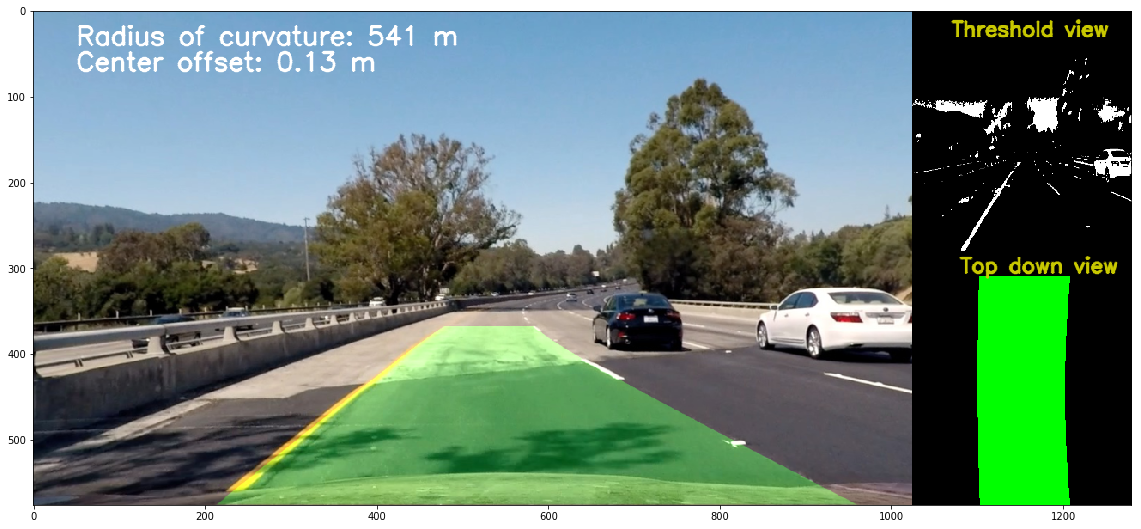

In [108]:
left = Line()
right = Line()

img_in = mpimg.imread('test_images/test4.jpg')
img_out = process_image(img_in)

plt.figure(figsize=(30,20))
#plt.subplot(2,1,1)
#plt.imshow(img_in)
plt.subplot(2,1,1)
plt.imshow(img_out)

In [109]:
from moviepy.editor import VideoFileClip

In [110]:
left = Line()
right = Line()
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:15<00:00,  6.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 15s


In [111]:
left = Line()
right = Line()
output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:14<00:00,  6.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 14s
